In [1]:
# Attribute Information:
#    1. Class: no-recurrence-events, recurrence-events
#    2. age: 10-19, 20-29, 30-39, 40-49, 50-59, 60-69, 70-79, 80-89, 90-99.
#    3. menopause: lt40, ge40, premeno.
#    4. tumor-size: 0-4, 5-9, 10-14, 15-19, 20-24, 25-29, 30-34, 35-39, 40-44,
#                   45-49, 50-54, 55-59.
#    5. inv-nodes: 0-2, 3-5, 6-8, 9-11, 12-14, 15-17, 18-20, 21-23, 24-26,
#                  27-29, 30-32, 33-35, 36-39.
#    6. node-caps: yes, no.
#    7. deg-malig: 1, 2, 3.
#    8. breast: left, right.
#    9. breast-quad: left-up, left-low, right-up,	right-low, central.
#   10. irradiat:	yes, no.

In [2]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
import time
from sklearn.metrics import accuracy_score, recall_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, precision_score

In [3]:
# Reading in the data
data_file_path = 'data/breast-cancer.data'
df = pd.read_csv(data_file_path, header=None)

In [4]:
df

,0,1,2,3,4,5,6,7,8,9
0,no-recurrence-events,30-39,premeno,30-34,0-2,no,3,left,left_low,no
1,no-recurrence-events,40-49,premeno,20-24,0-2,no,2,right,right_up,no
2,no-recurrence-events,40-49,premeno,20-24,0-2,no,2,left,left_low,no
3,no-recurrence-events,60-69,ge40,15-19,0-2,no,2,right,left_up,no
4,no-recurrence-events,40-49,premeno,0-4,0-2,no,2,right,right_low,no
...,...,...,...,...,...,...,...,...,...,...
281,recurrence-events,30-39,premeno,30-34,0-2,no,2,left,left_up,no
282,recurrence-events,30-39,premeno,20-24,0-2,no,3,left,left_up,yes
283,recurrence-events,60-69,ge40,20-24,0-2,no,1,right,left_up,no
284,recurrence-events,40-49,ge40,30-34,3-5,no,3,left,left_low,no


In [5]:
# Feature names
feature_names = ['Class', 'age', 'menopause', 'tumor-size', 'inv-nodes', 'node-caps', 'deg-malig', 'breast', 'breast-quad', 'irradiat']

In [6]:
# Renaming columns with proper feature names
df = df.rename(columns=dict(zip(df.columns, feature_names)))

In [7]:
df.head(5)

,Class,age,menopause,tumor-size,inv-nodes,node-caps,deg-malig,breast,breast-quad,irradiat
0,no-recurrence-events,30-39,premeno,30-34,0-2,no,3,left,left_low,no
1,no-recurrence-events,40-49,premeno,20-24,0-2,no,2,right,right_up,no
2,no-recurrence-events,40-49,premeno,20-24,0-2,no,2,left,left_low,no
3,no-recurrence-events,60-69,ge40,15-19,0-2,no,2,right,left_up,no
4,no-recurrence-events,40-49,premeno,0-4,0-2,no,2,right,right_low,no


## 1. Data Exploration

#### 1. Get an overview of dataset

In [8]:
# Get overview of dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 286 entries, 0 to 285
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Class        286 non-null    object
 1   age          286 non-null    object
 2   menopause    286 non-null    object
 3   tumor-size   286 non-null    object
 4   inv-nodes    286 non-null    object
 5   node-caps    286 non-null    object
 6   deg-malig    286 non-null    int64 
 7   breast       286 non-null    object
 8   breast-quad  286 non-null    object
 9   irradiat     286 non-null    object
dtypes: int64(1), object(9)
memory usage: 22.5+ KB


#### 2. Check for missing values

In [9]:
# Check for missing values
df.isnull().sum()

Class          0
age            0
menopause      0
tumor-size     0
inv-nodes      0
node-caps      0
deg-malig      0
breast         0
breast-quad    0
irradiat       0
dtype: int64

**Observations:**
- There are no missing values

#### 3. View Distribution of Each Feature

In [10]:
## Categories in Class
df['Class'].value_counts()

no-recurrence-events    201
recurrence-events        85
Name: Class, dtype: int64

In [11]:
## Display the distribution in terms of percentage
percentage = df['Class'].value_counts(normalize = True)*100
percentage

no-recurrence-events    70.27972
recurrence-events       29.72028
Name: Class, dtype: float64

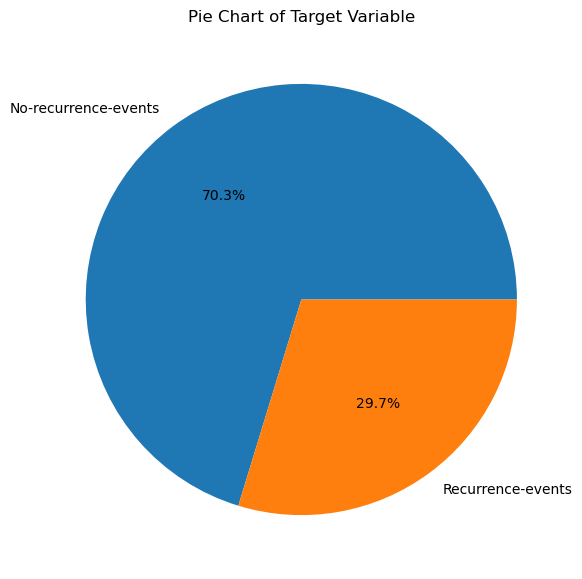

In [12]:
# Plotting piechart
classlabels = ["No-recurrence-events", "Recurrence-events"]
plt.figure(figsize=(12,7))
plt.pie(percentage, labels = classlabels, autopct='%1.1f%%')
plt.title("Pie Chart of Target Variable")
plt.show()

In [13]:
# Replace Class categories with 0, 1
df['Class'] = np.where(df['Class'] == 'no-recurrence-events', 0 , 1)

In [14]:
# Verify conversion worked properly
df['Class'].value_counts(normalize = True)*100

0    70.27972
1    29.72028
Name: Class, dtype: float64

In [15]:
# Define numerical and categorical columns using list comprehension
numeric_features = [feature for feature in df.columns if df[feature].dtype != 'O']
categorical_features = [feature for feature in df.columns if df[feature].dtype == 'O']

In [16]:
print("Numeric Features: ", numeric_features)
print("Categorical Features: ", categorical_features)

Numeric Features:  ['Class', 'deg-malig']
Categorical Features:  ['age', 'menopause', 'tumor-size', 'inv-nodes', 'node-caps', 'breast', 'breast-quad', 'irradiat']


In [17]:
# Display value counts for each class per feature
for feature in categorical_features:
    counts = df[feature].value_counts()
    percentage = (df[feature].value_counts(normalize = True) * 100).round(1).astype(str) + '%'
    print('Feature: ' + feature)
    print(pd.DataFrame({'count': counts, 'percentage': percentage}), '\n\n')

Feature: age
       count percentage
50-59     96      33.6%
40-49     90      31.5%
60-69     57      19.9%
30-39     36      12.6%
70-79      6       2.1%
20-29      1       0.3% 


Feature: menopause
         count percentage
premeno    150      52.4%
ge40       129      45.1%
lt40         7       2.4% 


Feature: tumor-size
       count percentage
30-34     60      21.0%
25-29     54      18.9%
20-24     50      17.5%
15-19     30      10.5%
10-14     28       9.8%
40-44     22       7.7%
35-39     19       6.6%
0-4        8       2.8%
50-54      8       2.8%
5-9        4       1.4%
45-49      3       1.0% 


Feature: inv-nodes
       count percentage
0-2      213      74.5%
3-5       36      12.6%
6-8       17       5.9%
9-11      10       3.5%
15-17      6       2.1%
12-14      3       1.0%
24-26      1       0.3% 


Feature: node-caps
     count percentage
no     222      77.6%
yes     56      19.6%
?        8       2.8% 


Feature: breast
       count percentage
left     152   

In [18]:
# Examine the distribution of 'Class' for each categorical features
for feature in categorical_features:
    grouped_by_feature = df.groupby(feature)['Class']
    grouped_by_feature = df.groupby(feature)['Class'].value_counts(normalize = True) * 100
    print(grouped_by_feature)

age    Class
20-29  0        100.000000
30-39  0         58.333333
       1         41.666667
40-49  0         70.000000
       1         30.000000
50-59  0         73.958333
       1         26.041667
60-69  0         70.175439
       1         29.824561
70-79  0         83.333333
       1         16.666667
Name: Class, dtype: float64
menopause  Class
ge40       0        72.868217
           1        27.131783
lt40       0        71.428571
           1        28.571429
premeno    0        68.000000
           1        32.000000
Name: Class, dtype: float64
tumor-size  Class
0-4         0         87.500000
            1         12.500000
10-14       0         96.428571
            1          3.571429
15-19       0         76.666667
            1         23.333333
20-24       0         68.000000
            1         32.000000
25-29       0         66.666667
            1         33.333333
30-34       0         58.333333
            1         41.666667
35-39       0         63.157895
   

#### 4. Visualize Data Distribution and Relationships 

To visualize and analyze the relationships between each categorical variable and the target variable, I will be using count plots. Using count plots will be more informative as it will allow us to look at the distribution of recurrence vs no recurrence for each group in the categorical variables.

In [19]:
df['age'].unique()

array(['30-39', '40-49', '60-69', '50-59', '70-79', '20-29'], dtype=object)

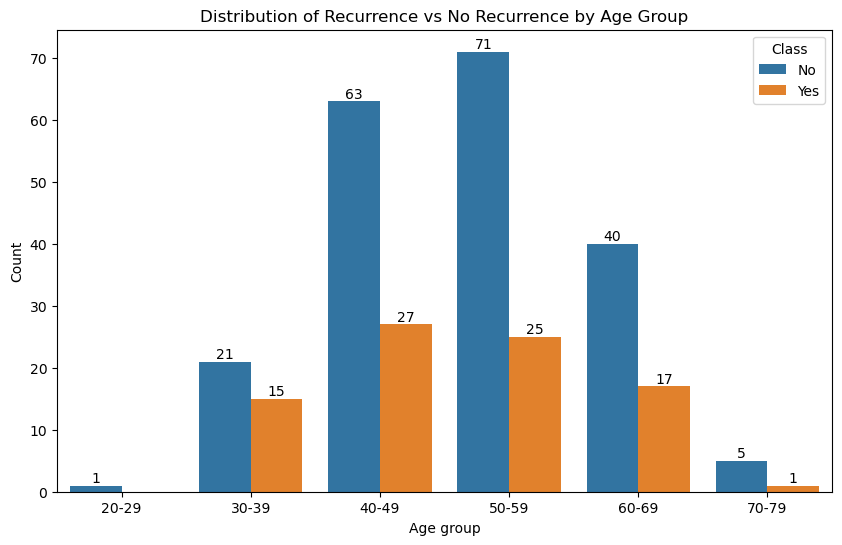

In [20]:
sorted_age = ['20-29', '30-39', '40-49', '50-59', '60-69', '70-79']

plt.figure(figsize=(10,6))
age_plot = sns.countplot(x = 'age', hue = 'Class', data = df, order = sorted_age)
plt.title('Distribution of Recurrence vs No Recurrence by Age Group')
plt.xlabel('Age group')
plt.ylabel('Count')
plt.legend(title = 'Class', labels = ["No", 'Yes'])

# label distribution count for each group
for container in age_plot.containers:
    age_plot.bar_label(container)

**Observations:**
1. Middle age groups (40-49, 50,59) have highest counts of non-recurrence with 63 and 71 instances respectively.
2. Across all age groups, the middle age groups (40-49, 50,59) also show relatively high counts of recurrence, with 27 and 25 instances respectively, though these numbers are still lower compared to number of non-recurrence cases in the same age groups
3. Number of non-recurrence case is consistently higher across all age groups
4. Number of non-recurrence cases increases as age increases, peaking at age group 50-59

In [21]:
df['menopause'].unique()

array(['premeno', 'ge40', 'lt40'], dtype=object)

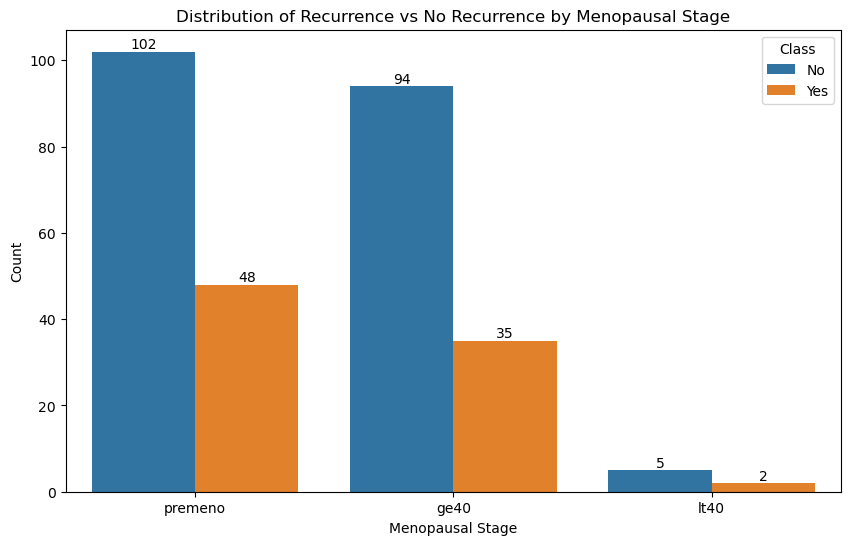

In [22]:
plt.figure(figsize=(10,6))
menopause_plot = sns.countplot(x = 'menopause', hue = 'Class', data = df)
plt.title('Distribution of Recurrence vs No Recurrence by Menopausal Stage')
plt.xlabel('Menopausal Stage')
plt.ylabel('Count')
plt.legend(title = 'Class', labels = ["No", 'Yes'])

# label distribution count for each group
for container in menopause_plot.containers:
    menopause_plot.bar_label(container)

In [23]:
# Visualize proportion of recurrence within each group using pie chart
group_by_menopause = df.groupby('menopause')['Class'].value_counts(normalize = True) * 100
df_menopause = group_by_menopause.reset_index(name = 'percentage')
df_menopause

,menopause,Class,percentage
0,ge40,0,72.868217
1,ge40,1,27.131783
2,lt40,0,71.428571
3,lt40,1,28.571429
4,premeno,0,68.000000
5,premeno,1,32.000000


In [24]:
# Separate data based on menopausal stage
ge40_menopause = df_menopause[df_menopause['menopause'] == 'ge40']
lt40_menopause = df_menopause[df_menopause['menopause'] == 'lt40']
premeno_menopause = df_menopause[df_menopause['menopause'] == 'premeno']

In [25]:
premeno_menopause

,menopause,Class,percentage
4,premeno,0,68.0
5,premeno,1,32.0


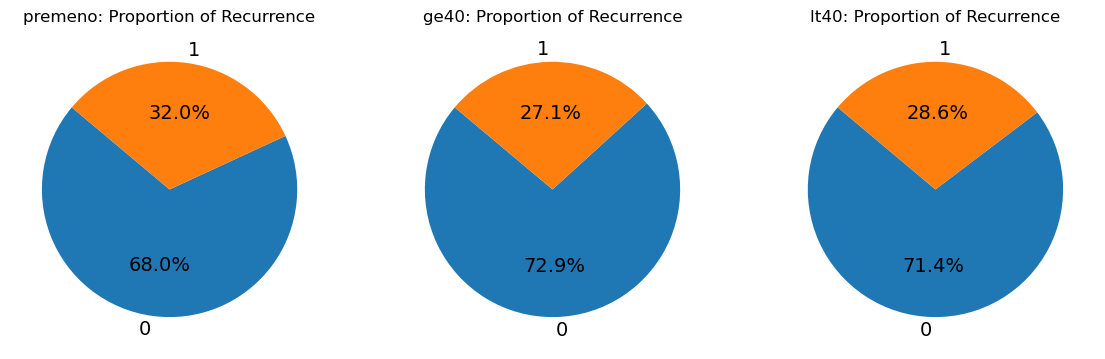

In [26]:
fig, ax = plt.subplots(1, 3, figsize=(14, 10))

ax[0].pie(premeno_menopause['percentage'], labels=premeno_menopause['Class'], autopct='%1.1f%%', startangle=140, textprops={'fontsize': 14})
ax[0].set_title('premeno: Proportion of Recurrence')

ax[1].pie(ge40_menopause['percentage'], labels=ge40_menopause['Class'], autopct='%1.1f%%', startangle=140, textprops={'fontsize': 14})
ax[1].set_title('ge40: Proportion of Recurrence')

ax[2].pie(lt40_menopause['percentage'], labels=lt40_menopause['Class'], autopct='%1.1f%%', startangle=140, textprops={'fontsize': 14})
ax[2].set_title('lt40: Proportion of Recurrence')

plt.show()

**Definitions of different stages:**
- Premeno: Premenopausal (before menopause)
- ge40: Age 40 and above (typically postmenopausal)
- lt40: Age less than 40 (typically premenopausal)

**Observations:**
- Premenopausal stage has the highest count of both non-recurrence (102) and recurrence (48) cases. Recurrence cases make up 32% of total cases.
- ge40 stage has a slightly lower count of non-recurrence and recurrence cases compared to premeno. Recurrence cases make up ~27% of total cases
- lt40 has the lowest count in both classes due to fewer cases in dataset, making it difficult to extract meaningful information

**Takeaway:**
- Women in premenopausal stage and ge40 stage are at higher risk of recurrence.

In [27]:
df['tumor-size'].unique()

array(['30-34', '20-24', '15-19', '0-4', '25-29', '50-54', '10-14',
       '40-44', '35-39', '5-9', '45-49'], dtype=object)

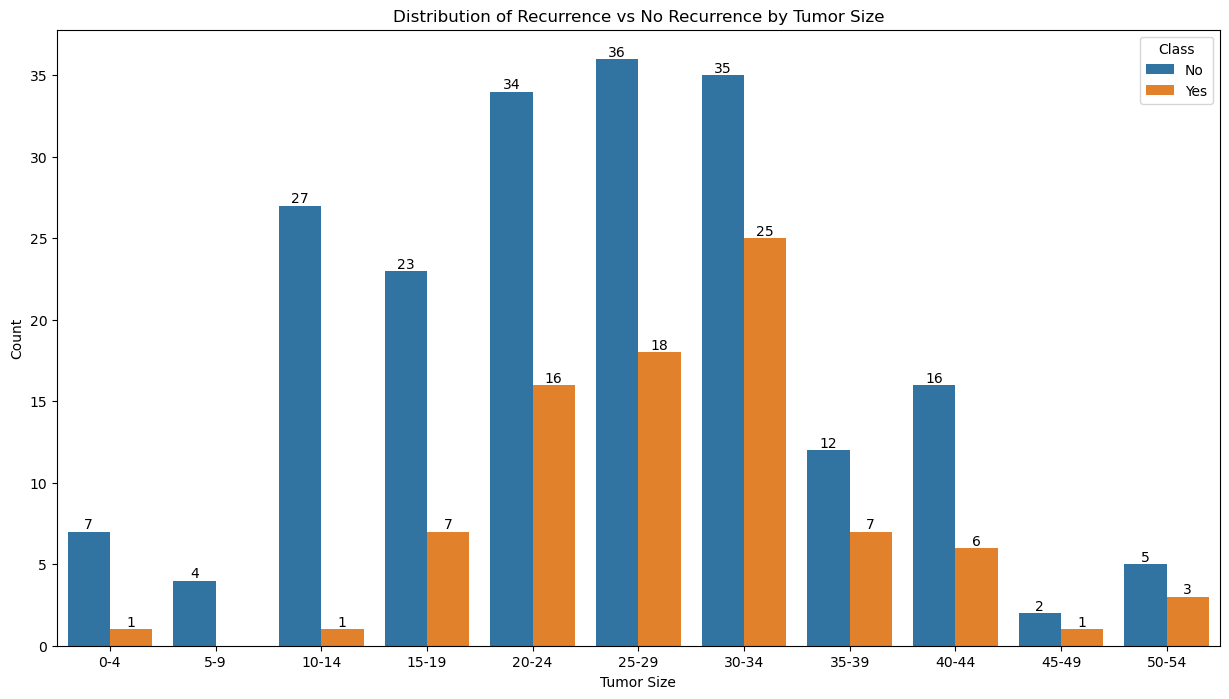

In [28]:
sorted_size = ['0-4','5-9','10-14','15-19','20-24','25-29','30-34','35-39','40-44','45-49','50-54']
plt.figure(figsize=(15,8))
tumor_size_plot = sns.countplot(x = 'tumor-size', hue = 'Class', data = df, order = sorted_size)
plt.title('Distribution of Recurrence vs No Recurrence by Tumor Size')
plt.xlabel('Tumor Size')
plt.ylabel('Count')
plt.legend(title = 'Class', labels = ["No", 'Yes'])

# label distribution count for each group
for container in tumor_size_plot.containers:
    tumor_size_plot.bar_label(container)

**Observations:**
- As tumor size increase, risk of recurrence also increases. In particular, tumor sizes in the following groups: 20-24, 25-29, 30-34 show a particularly high risk of recurrence.

In [29]:
df['inv-nodes'].unique()

array(['0-2', '6-8', '9-11', '3-5', '15-17', '12-14', '24-26'],
      dtype=object)

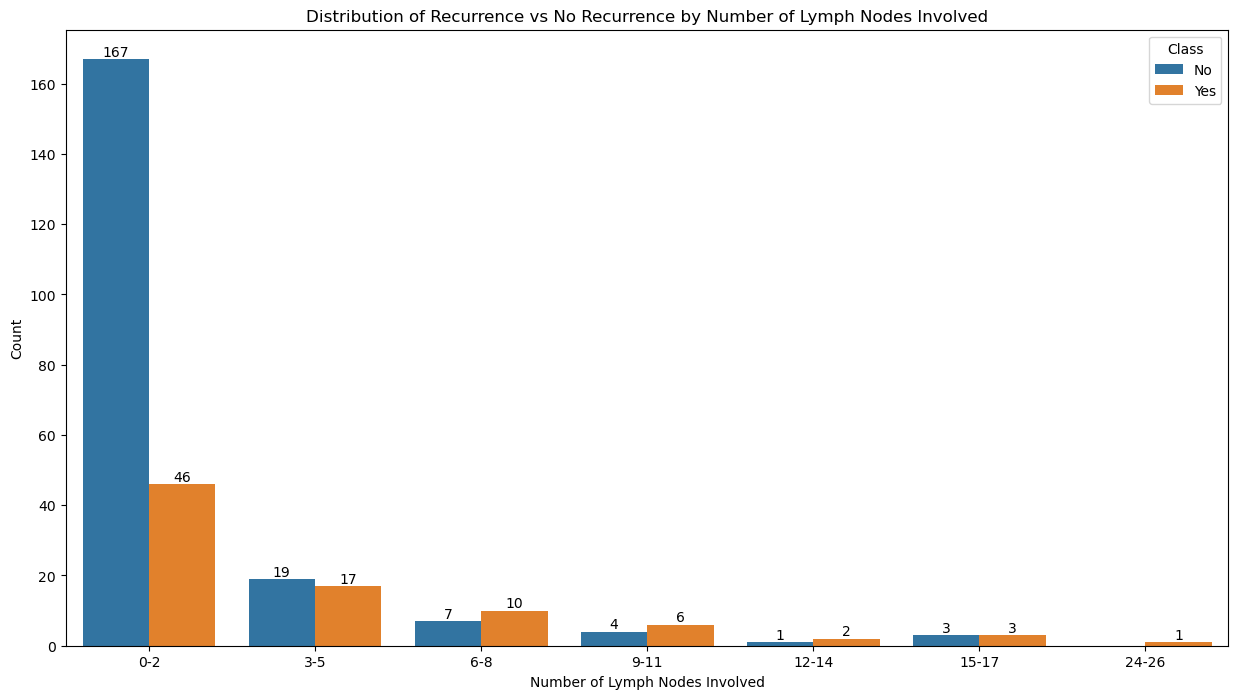

In [30]:
sorted_nodes = ['0-2','3-5','6-8','9-11','12-14','15-17','24-26']
plt.figure(figsize=(15,8))
nodes_involved_plot = sns.countplot(x = 'inv-nodes', hue = 'Class', data = df, order = sorted_nodes)
plt.title('Distribution of Recurrence vs No Recurrence by Number of Lymph Nodes Involved')
plt.xlabel('Number of Lymph Nodes Involved')
plt.ylabel('Count')
plt.legend(title = 'Class', labels = ["No", 'Yes'])

# label distribution count for each group
for container in nodes_involved_plot.containers:
    nodes_involved_plot.bar_label(container)

**Observations:**
- Majority of patients fall into first group (0-2 lymph nodes involved).
- Patients with low lymph node involvement (0-2)ß have relatively lower risk of reucrrence.
- From 3-5 lymph nodes and onwards, there is approximately an equal proportion of non-reucurrence and recurrence cases (suggesting higher risk of recurrence)

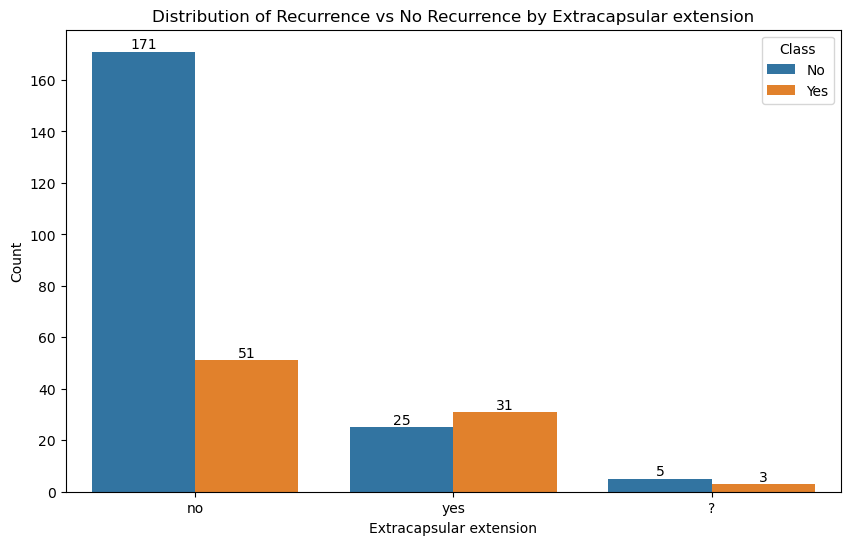

In [31]:
plt.figure(figsize=(10,6))
node_caps_plot = sns.countplot(x = 'node-caps', hue = 'Class', data = df)
plt.title('Distribution of Recurrence vs No Recurrence by Extracapsular extension')
plt.xlabel('Extracapsular extension')
plt.ylabel('Count')
plt.legend(title = 'Class', labels = ["No", 'Yes'])

# label distribution count for each group
for container in node_caps_plot.containers:
    node_caps_plot.bar_label(container)

In [32]:
# Visualize proportion of recurrence within each group using pie chart
group_by_node_caps = df.groupby('node-caps')['Class'].value_counts(normalize = True) * 100
df_node_caps = group_by_node_caps.reset_index(name = 'percentage')
df_node_caps

,node-caps,Class,percentage
0,?,0,62.500000
1,?,1,37.500000
2,no,0,77.027027
3,no,1,22.972973
4,yes,1,55.357143
5,yes,0,44.642857


In [33]:
# Separate data based on extracapsular extension
node_caps_no = df_node_caps[df_node_caps['node-caps'] == 'no']
node_caps_yes = df_node_caps[df_node_caps['node-caps'] == 'yes']
node_caps_unknown = df_node_caps[df_node_caps['node-caps'] == '?']

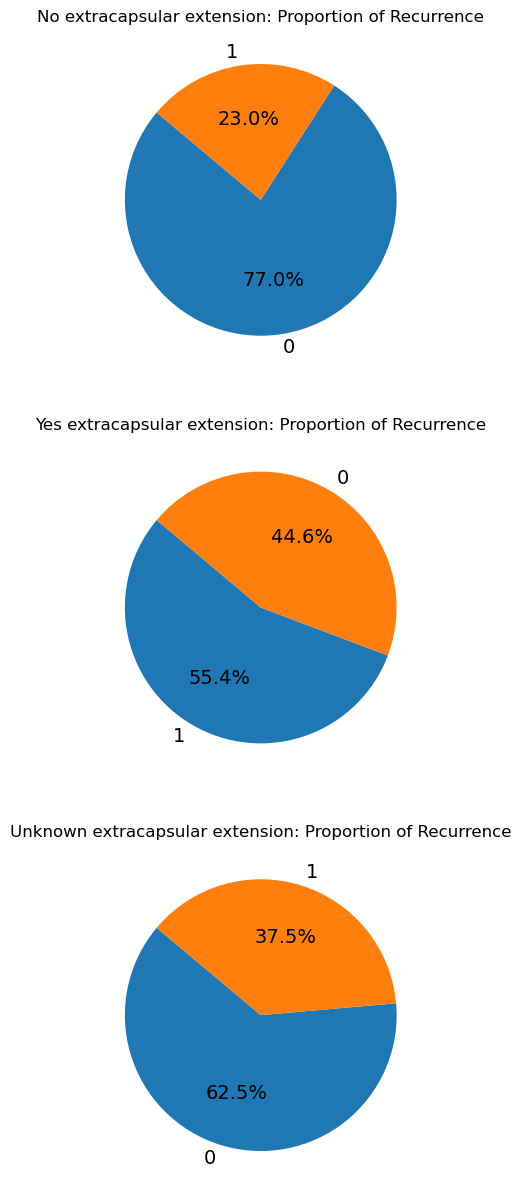

In [34]:
fig, ax = plt.subplots(3, 1, figsize=(10, 15))

ax[0].pie(node_caps_no['percentage'], labels=node_caps_no['Class'], autopct='%1.1f%%', startangle=140, textprops={'fontsize': 14})
ax[0].set_title('No extracapsular extension: Proportion of Recurrence')

ax[1].pie(node_caps_yes['percentage'], labels=node_caps_yes['Class'], autopct='%1.1f%%', startangle=140, textprops={'fontsize': 14})
ax[1].set_title('Yes extracapsular extension: Proportion of Recurrence')

ax[2].pie(node_caps_unknown['percentage'], labels=node_caps_unknown['Class'], autopct='%1.1f%%', startangle=140, textprops={'fontsize': 14})
ax[2].set_title('Unknown extracapsular extension: Proportion of Recurrence')

plt.show()

**Defintion of Extracapsular Extension:**
- Yes means cancer cells have broken through the lymph node capsule and spread to surrounding tissues.
- No means cancer cells are contained within the lymph node capsule.

**Observations:**
- Majority of patients fall under no extracapsular extension group, with high count of non-recurrence cases. 
- The proportion of recurrence is highest in 'yes'
- This suggests that patients with no extracapsular extension have higher likelihood of non-reucrrence

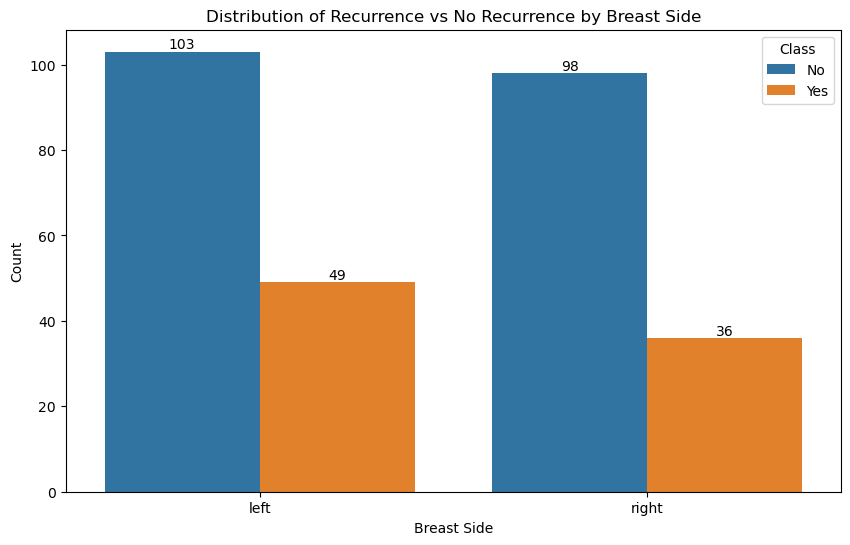

In [35]:
plt.figure(figsize=(10,6))
breast_plot = sns.countplot(x = 'breast', hue = 'Class', data = df)
plt.title('Distribution of Recurrence vs No Recurrence by Breast Side')
plt.xlabel('Breast Side')
plt.ylabel('Count')
plt.legend(title = 'Class', labels = ["No", 'Yes'])

# label distribution count for each group
for container in breast_plot.containers:
    breast_plot.bar_label(container)

**Observations:**
- Both left and right side have similar amount of non-recurrence and recurrence cases.
- Left side has a slightly higher percentage of reucrrence cases

In [36]:
df['breast-quad'].unique()

array(['left_low', 'right_up', 'left_up', 'right_low', 'central', '?'],
      dtype=object)

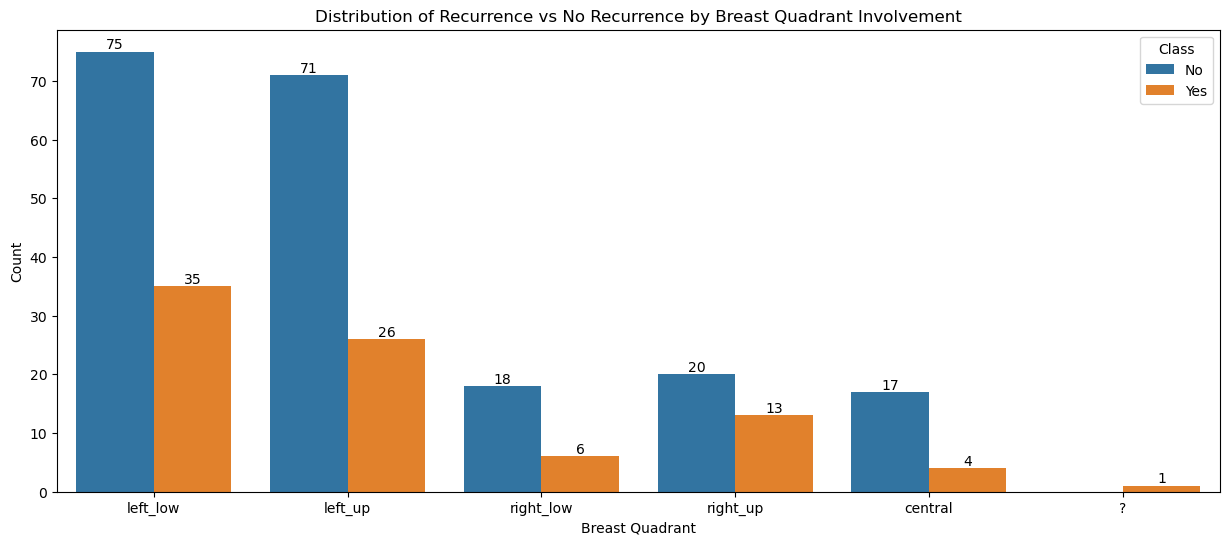

In [37]:
sorted_quad = ['left_low','left_up','right_low','right_up','central', '?']
plt.figure(figsize=(15,6))
breast_quad_plot = sns.countplot(x = 'breast-quad', hue = 'Class', data = df, order = sorted_quad)
plt.title('Distribution of Recurrence vs No Recurrence by Breast Quadrant Involvement')
plt.xlabel('Breast Quadrant')
plt.ylabel('Count')
plt.legend(title = 'Class', labels = ["No", 'Yes'])

# label distribution count for each group
for container in breast_quad_plot.containers:
    breast_quad_plot.bar_label(container)

**Observations:**
- Left lower and upper quadrant have the highest counts of non-recurrence but also have notable amounts of recurrence.
- Right upper quadrant exhibits higher proportion of recurrence to other quadrants, which may suggest higher risk
- Central quadrant shows the lowest proportion of recurrence

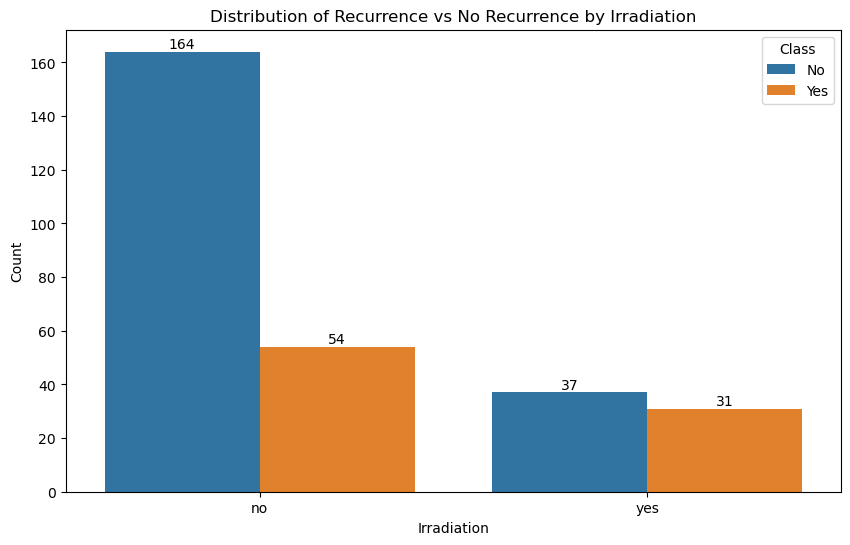

In [38]:
plt.figure(figsize=(10,6))
irradiat_plot = sns.countplot(x = 'irradiat', hue = 'Class', data = df)
plt.title('Distribution of Recurrence vs No Recurrence by Irradiation')
plt.xlabel('Irradiation')
plt.ylabel('Count')
plt.legend(title = 'Class', labels = ["No", 'Yes'])

# label distribution count for each group
for container in irradiat_plot.containers:
    irradiat_plot.bar_label(container)

**Observations:**
- Data shows that patients who received irradiation have a higher proportion of recurence compared to patients who did not receive irradiation. This seems a bit conterintuitive since irradation is supposed to help destory cancer cells

In [39]:
# Examining relationship between numerical feature and target variable
grouped_by_feature = df.groupby('deg-malig')['Class']
grouped_by_feature = df.groupby('deg-malig')['Class'].value_counts(normalize = True) * 100
print(grouped_by_feature)

deg-malig  Class
1          0        83.098592
           1        16.901408
2          0        78.461538
           1        21.538462
3          1        52.941176
           0        47.058824
Name: Class, dtype: float64


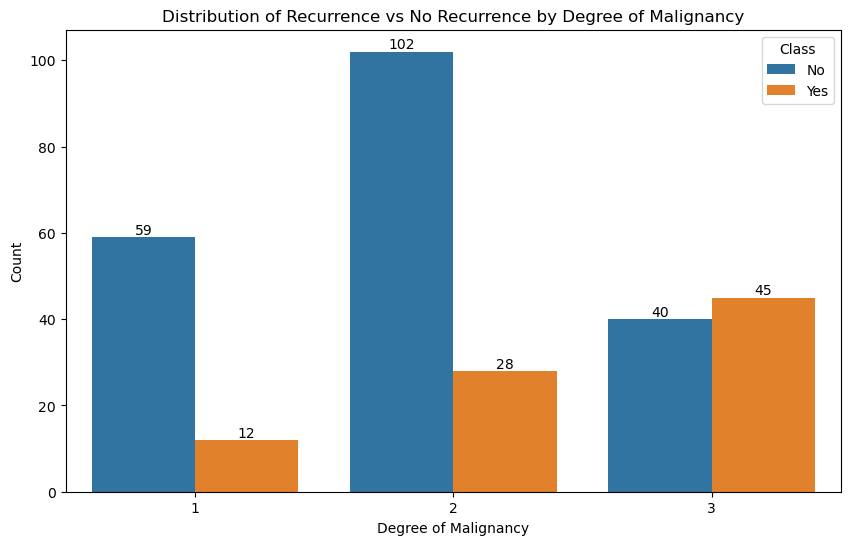

In [40]:
plt.figure(figsize=(10,6))
deg_malig_plot = sns.countplot(x = 'deg-malig', hue = 'Class', data = df)
plt.title('Distribution of Recurrence vs No Recurrence by Degree of Malignancy')
plt.xlabel('Degree of Malignancy')
plt.ylabel('Count')
plt.legend(title = 'Class', labels = ["No", 'Yes'])

# label distribution count for each group
for container in deg_malig_plot.containers:
    deg_malig_plot.bar_label(container)

**Observations:**
- Patients with degree of malignancy 3 have the highest recurrence rate 
- Proportion of recurrence increases as degree of malignancy increases

In [41]:
# This dataframe only contains a single numerical feature besides target variable. Therefore, unable to utilize
# heat map to view correlation

## 2. Data Preprocessing

According to this article https://www.healthline.com/health/breast-cancer/breast-cancer-tumor-size-chart#tumor-growth-rate, tumor-size in breast cancer is typically categorized as follows:
- T0: This size of tumor is considered noninvasive. It’s very small and hasn’t spread.
- T1: This tumor is less than 2 centimeters (3/4 inch). It may or may not have spread to nearby lymph nodes.
- T2: This tumor is slightly larger, between 2 and 5 centimeters. Some stage 2 tumors are larger but haven’t spread to the lymph nodes. Others may be small but have spread to nearby lymph nodes.
- T3: Tumor is greater than 5 cm.
- T4: Tumor of any size with invasion into the chest wall or skin.

We will use this grouping to restructure the tumor-size feature into T1, T2 and T3. 

In [42]:
# creating function to categorize tumor size based on criteria above
def categorize_tumor_sizes(df):
    # less than 2 cm
    group1 = ['0-4', '5-9', '10-14', '15-19']
    # between 2 cm and 5 cm
    group2 = ['20-24', '25-29', '30-34', '35-39', '40-44', '45-49']
    # greater than 5 cm
    group3 = ['50-54']
    
    # Assign tumor_size into appropriate category
    def assign_group(tumor_size):
        if tumor_size in group1:
            return '1'
        elif tumor_size in group2:
            return '2'
        elif tumor_size in group3:
            return '3' 

    df['tumor-size'] = df['tumor-size'].map(assign_group)
    return df

In [43]:
# verify conversion works
df_updated = categorize_tumor_sizes(df)

In [44]:
df_updated

,Class,age,menopause,tumor-size,inv-nodes,node-caps,deg-malig,breast,breast-quad,irradiat
0,0,30-39,premeno,2,0-2,no,3,left,left_low,no
1,0,40-49,premeno,2,0-2,no,2,right,right_up,no
2,0,40-49,premeno,2,0-2,no,2,left,left_low,no
3,0,60-69,ge40,1,0-2,no,2,right,left_up,no
4,0,40-49,premeno,1,0-2,no,2,right,right_low,no
...,...,...,...,...,...,...,...,...,...,...
281,1,30-39,premeno,2,0-2,no,2,left,left_up,no
282,1,30-39,premeno,2,0-2,no,3,left,left_up,yes
283,1,60-69,ge40,2,0-2,no,1,right,left_up,no
284,1,40-49,ge40,2,3-5,no,3,left,left_low,no


In [45]:
# Display value counts for each class per feature
for feature in df_updated.columns:
    counts = df_updated[feature].value_counts()
    percentage = (df_updated[feature].value_counts(normalize = True) * 100).round(1).astype(str) + '%'
    print('Feature: ' + feature)
    print(pd.DataFrame({'count': counts, 'percentage': percentage}), '\n\n')

Feature: Class
   count percentage
0    201      70.3%
1     85      29.7% 


Feature: age
       count percentage
50-59     96      33.6%
40-49     90      31.5%
60-69     57      19.9%
30-39     36      12.6%
70-79      6       2.1%
20-29      1       0.3% 


Feature: menopause
         count percentage
premeno    150      52.4%
ge40       129      45.1%
lt40         7       2.4% 


Feature: tumor-size
   count percentage
2    208      72.7%
1     70      24.5%
3      8       2.8% 


Feature: inv-nodes
       count percentage
0-2      213      74.5%
3-5       36      12.6%
6-8       17       5.9%
9-11      10       3.5%
15-17      6       2.1%
12-14      3       1.0%
24-26      1       0.3% 


Feature: node-caps
     count percentage
no     222      77.6%
yes     56      19.6%
?        8       2.8% 


Feature: deg-malig
   count percentage
2    130      45.5%
3     85      29.7%
1     71      24.8% 


Feature: breast
       count percentage
left     152      53.1%
right    134      4

In [46]:
# convert type to int
df_updated['tumor-size'] = df_updated['tumor-size'].astype(int)

In [47]:
# df_updated.info()

#### Data Transformation

In [48]:
from sklearn.preprocessing import OrdinalEncoder

# Define the custom order
age_order = ['20-29', '30-39', '40-49', '50-59', '60-69', '70-79']

inv_nodes_order = ['0-2', '3-5', '6-8', '9-11', '12-14', '15-17', '24-26']

# Initialize the OrdinalEncoder with custom categories
ordinal_encoder = OrdinalEncoder(categories=[age_order])

# Fit and transform the data
df_updated['age_encoded'] = ordinal_encoder.fit_transform(df_updated[['age']])

ordinal_encoder = OrdinalEncoder(categories=[inv_nodes_order])

# Fit and transform the data
df_updated['inv-nodes_encoded'] = ordinal_encoder.fit_transform(df_updated[['inv-nodes']])

In [49]:
df_updated.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 286 entries, 0 to 285
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Class              286 non-null    int64  
 1   age                286 non-null    object 
 2   menopause          286 non-null    object 
 3   tumor-size         286 non-null    int64  
 4   inv-nodes          286 non-null    object 
 5   node-caps          286 non-null    object 
 6   deg-malig          286 non-null    int64  
 7   breast             286 non-null    object 
 8   breast-quad        286 non-null    object 
 9   irradiat           286 non-null    object 
 10  age_encoded        286 non-null    float64
 11  inv-nodes_encoded  286 non-null    float64
dtypes: float64(2), int64(3), object(7)
memory usage: 26.9+ KB


In [50]:
df_updated['inv-nodes'].value_counts(normalize = True) * 100

0-2      74.475524
3-5      12.587413
6-8       5.944056
9-11      3.496503
15-17     2.097902
12-14     1.048951
24-26     0.349650
Name: inv-nodes, dtype: float64

In [51]:
df_updated['inv-nodes_encoded'].value_counts(normalize = True) * 100

0.0    74.475524
1.0    12.587413
2.0     5.944056
3.0     3.496503
5.0     2.097902
4.0     1.048951
6.0     0.349650
Name: inv-nodes_encoded, dtype: float64

In [52]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

df_updated['breast_encoded'] = label_encoder.fit_transform(df_updated['breast'])
df_updated['irradiat_encoded'] = label_encoder.fit_transform(df_updated['irradiat'])

In [53]:
#df_updated['breast'] = np.where(df_updated['breast'] == 'left', 0 , 1)

In [54]:
#df_updated['irradiat'] = np.where(df_updated['irradiat'] == 'no', 0 , 1)

In [55]:
df['breast'].value_counts(normalize = True) * 100

left     53.146853
right    46.853147
Name: breast, dtype: float64

In [56]:
df.head()

,Class,age,menopause,tumor-size,inv-nodes,node-caps,deg-malig,breast,breast-quad,irradiat,age_encoded,inv-nodes_encoded,breast_encoded,irradiat_encoded
0,0,30-39,premeno,2,0-2,no,3,left,left_low,no,1.0,0.0,0,0
1,0,40-49,premeno,2,0-2,no,2,right,right_up,no,2.0,0.0,1,0
2,0,40-49,premeno,2,0-2,no,2,left,left_low,no,2.0,0.0,0,0
3,0,60-69,ge40,1,0-2,no,2,right,left_up,no,4.0,0.0,1,0
4,0,40-49,premeno,1,0-2,no,2,right,right_low,no,2.0,0.0,1,0


In [57]:
df_updated['breast'].value_counts(normalize = True) * 100

left     53.146853
right    46.853147
Name: breast, dtype: float64

In [58]:
df_updated.head()

,Class,age,menopause,tumor-size,inv-nodes,node-caps,deg-malig,breast,breast-quad,irradiat,age_encoded,inv-nodes_encoded,breast_encoded,irradiat_encoded
0,0,30-39,premeno,2,0-2,no,3,left,left_low,no,1.0,0.0,0,0
1,0,40-49,premeno,2,0-2,no,2,right,right_up,no,2.0,0.0,1,0
2,0,40-49,premeno,2,0-2,no,2,left,left_low,no,2.0,0.0,0,0
3,0,60-69,ge40,1,0-2,no,2,right,left_up,no,4.0,0.0,1,0
4,0,40-49,premeno,1,0-2,no,2,right,right_low,no,2.0,0.0,1,0


In [59]:
# One hot encode menopause and node-caps feature using pd.getdummies

df_final = pd.get_dummies(df_updated, columns = ['menopause', 'node-caps', 'breast-quad'])
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 286 entries, 0 to 285
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Class                  286 non-null    int64  
 1   age                    286 non-null    object 
 2   tumor-size             286 non-null    int64  
 3   inv-nodes              286 non-null    object 
 4   deg-malig              286 non-null    int64  
 5   breast                 286 non-null    object 
 6   irradiat               286 non-null    object 
 7   age_encoded            286 non-null    float64
 8   inv-nodes_encoded      286 non-null    float64
 9   breast_encoded         286 non-null    int64  
 10  irradiat_encoded       286 non-null    int64  
 11  menopause_ge40         286 non-null    uint8  
 12  menopause_lt40         286 non-null    uint8  
 13  menopause_premeno      286 non-null    uint8  
 14  node-caps_?            286 non-null    uint8  
 15  node-c

In [60]:
# Drop original columns 
df_final.drop(columns = ['age', 'inv-nodes', 'breast', 'irradiat'], axis = 1, inplace = True)

In [61]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 286 entries, 0 to 285
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Class                  286 non-null    int64  
 1   tumor-size             286 non-null    int64  
 2   deg-malig              286 non-null    int64  
 3   age_encoded            286 non-null    float64
 4   inv-nodes_encoded      286 non-null    float64
 5   breast_encoded         286 non-null    int64  
 6   irradiat_encoded       286 non-null    int64  
 7   menopause_ge40         286 non-null    uint8  
 8   menopause_lt40         286 non-null    uint8  
 9   menopause_premeno      286 non-null    uint8  
 10  node-caps_?            286 non-null    uint8  
 11  node-caps_no           286 non-null    uint8  
 12  node-caps_yes          286 non-null    uint8  
 13  breast-quad_?          286 non-null    uint8  
 14  breast-quad_central    286 non-null    uint8  
 15  breast

In [62]:
# for feature in df_final.columns:
#     counts = df_final[feature].value_counts()
#     percentage = (df_final[feature].value_counts(normalize = True) * 100).round(1).astype(str) + '%'
#     print('Feature: ' + feature)
#     print(pd.DataFrame({'count': counts, 'percentage': percentage}), '\n\n')

#### Feature Scaling


In [63]:
from sklearn.preprocessing import StandardScaler
# only apply scaling on ordinal features
features_to_scale = ['tumor-size', 'deg-malig', 'age_encoded', 'inv-nodes_encoded']

scaler = StandardScaler()

df_final[features_to_scale] = scaler.fit_transform(df_final[features_to_scale])

In [64]:
df_final.head()

,Class,tumor-size,deg-malig,age_encoded,inv-nodes_encoded,breast_encoded,irradiat_encoded,menopause_ge40,menopause_lt40,menopause_premeno,node-caps_?,node-caps_no,node-caps_yes,breast-quad_?,breast-quad_central,breast-quad_left_low,breast-quad_left_up,breast-quad_right_low,breast-quad_right_up
0,0,0.456277,1.290564,-1.647779,-0.466842,0,0,0,0,1,0,1,0,0,0,1,0,0,0
1,0,0.456277,-0.066426,-0.657727,-0.466842,1,0,0,0,1,0,1,0,0,0,0,0,0,1
2,0,0.456277,-0.066426,-0.657727,-0.466842,0,0,0,0,1,0,1,0,0,0,1,0,0,0
3,0,-1.648485,-0.066426,1.322377,-0.466842,1,0,1,0,0,0,1,0,0,0,0,1,0,0
4,0,-1.648485,-0.066426,-0.657727,-0.466842,1,0,0,0,1,0,1,0,0,0,0,0,1,0


In [65]:
df_final.shape

(286, 19)

## 3. Exploration of Different Classification Models

In [66]:
# Train test split
y = df_final['Class']
X = df_final.drop(columns='Class', axis=1)

In [67]:
y

0      0
1      0
2      0
3      0
4      0
      ..
281    1
282    1
283    1
284    1
285    1
Name: Class, Length: 286, dtype: int64

In [68]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 286 entries, 0 to 285
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   tumor-size             286 non-null    float64
 1   deg-malig              286 non-null    float64
 2   age_encoded            286 non-null    float64
 3   inv-nodes_encoded      286 non-null    float64
 4   breast_encoded         286 non-null    int64  
 5   irradiat_encoded       286 non-null    int64  
 6   menopause_ge40         286 non-null    uint8  
 7   menopause_lt40         286 non-null    uint8  
 8   menopause_premeno      286 non-null    uint8  
 9   node-caps_?            286 non-null    uint8  
 10  node-caps_no           286 non-null    uint8  
 11  node-caps_yes          286 non-null    uint8  
 12  breast-quad_?          286 non-null    uint8  
 13  breast-quad_central    286 non-null    uint8  
 14  breast-quad_left_low   286 non-null    uint8  
 15  breast

In [69]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.30, random_state=42, stratify = y)

In [70]:
X_train.corr()

,tumor-size,deg-malig,age_encoded,inv-nodes_encoded,breast_encoded,irradiat_encoded,menopause_ge40,menopause_lt40,menopause_premeno,node-caps_?,node-caps_no,node-caps_yes,breast-quad_?,breast-quad_central,breast-quad_left_low,breast-quad_left_up,breast-quad_right_low,breast-quad_right_up
tumor-size,1.000000,0.176122,-0.061993,0.086711,0.053748,0.125220,-0.020262,-0.057883,0.038282,0.032314,-0.164441,0.159255,0.032946,-0.178640,-0.028879,0.050145,-0.043514,0.163391
deg-malig,0.176122,1.000000,-0.073797,0.316214,-0.072745,0.207480,0.080293,-0.137890,-0.036817,-0.156618,-0.227348,0.311813,0.092766,-0.038619,-0.008286,0.008874,-0.014466,0.026655
age_encoded,-0.061993,-0.073797,1.000000,-0.070218,-0.051236,0.005728,0.696844,0.046072,-0.708278,0.135773,0.012545,-0.075080,0.020396,-0.030855,0.025276,0.070372,-0.125760,-0.009830
inv-nodes_encoded,0.086711,0.316214,-0.070218,1.000000,-0.043144,0.275003,0.039258,-0.077813,-0.014749,0.116893,-0.538041,0.515989,-0.034448,-0.085573,0.046140,-0.054237,0.110673,-0.001691
breast_encoded,0.053748,-0.072745,-0.051236,-0.043144,1.000000,0.023113,-0.054776,-0.089744,0.082615,-0.074061,0.071238,-0.041648,-0.068107,-0.022381,-0.238797,0.218875,-0.077514,0.142017
irradiat_encoded,0.125220,0.207480,0.005728,0.275003,0.023113,1.000000,0.017426,-0.092450,0.011568,0.204200,-0.351480,0.278878,-0.040927,-0.100871,-0.011958,0.024376,0.113863,-0.018452
menopause_ge40,-0.020262,0.080293,0.696844,0.039258,-0.054776,0.017426,1.000000,-0.143384,-0.950873,0.048449,0.008481,-0.031028,0.079166,0.069961,0.001459,0.058195,-0.092536,-0.089713
menopause_lt40,-0.057883,-0.137890,0.046072,-0.077813,-0.089744,-0.092450,-0.143384,1.000000,-0.170042,0.318026,-0.059990,-0.081313,-0.011351,-0.050358,0.009950,0.020282,-0.048805,0.046059
menopause_premeno,0.038282,-0.036817,-0.708278,-0.014749,0.082615,0.011568,-0.950873,-0.170042,1.000000,-0.147725,0.010321,0.056331,-0.075277,-0.053909,-0.004565,-0.064290,0.107407,0.074922
node-caps_?,0.032314,-0.156618,0.135773,0.116893,-0.074061,0.204200,0.048449,0.318026,-0.147725,1.000000,-0.338900,-0.096708,-0.013500,-0.059892,0.023104,0.035608,0.039510,-0.066953


<AxesSubplot:>

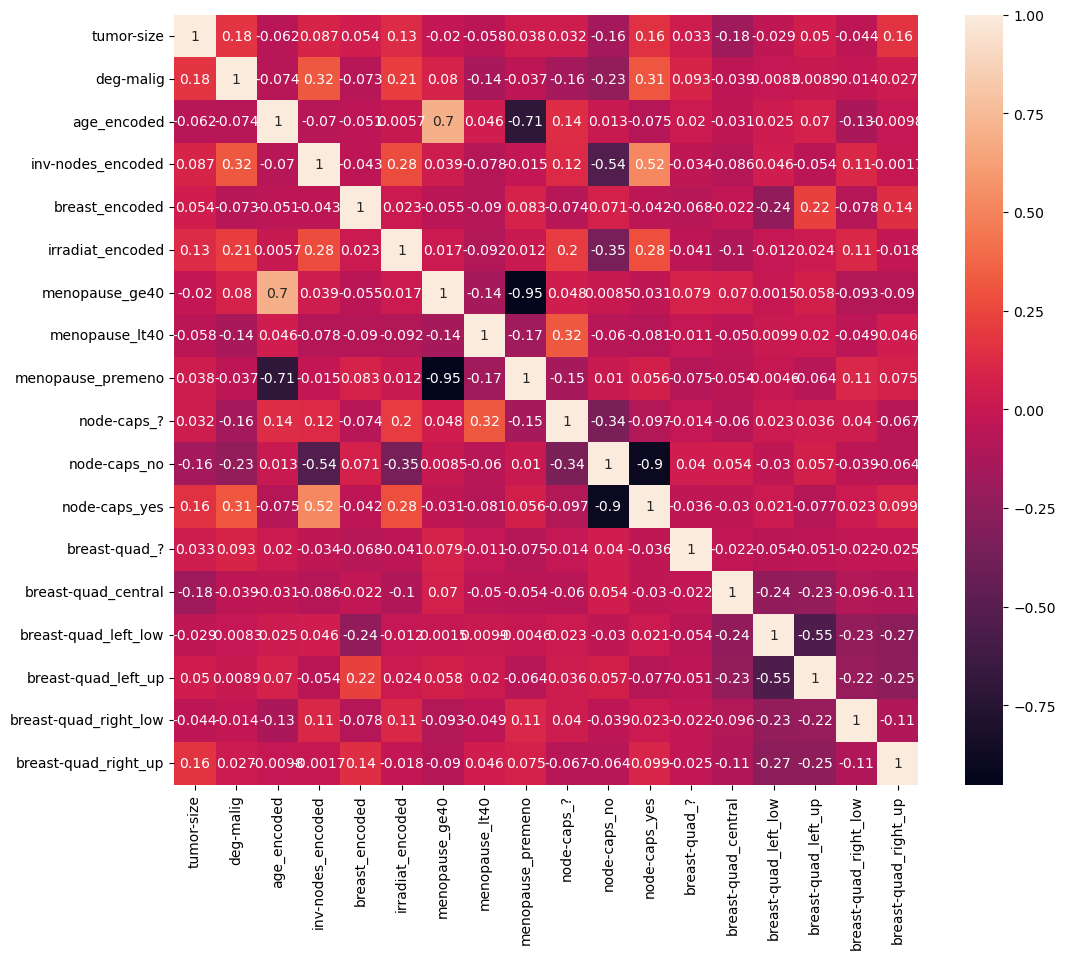

In [71]:
plt.figure(figsize=(12,10))
corr = X_train.corr()
sns.heatmap(corr, annot=True)

In [72]:
# creating base line models

models = {
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(),
    'KNeighbors': KNeighborsClassifier(),
    'Support Vector machine': SVC()
}

for i in range(len(list(models))):
    model = list(models.values())[i]
    model.fit(X_train, y_train)
    
    # Predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Training set performance
    model_train_accuracy = accuracy_score(y_train, y_train_pred)
    model_train_precision = precision_score(y_train, y_train_pred)
    model_train_recall = recall_score(y_train, y_train_pred)
    model_train_f1 = f1_score(y_train, y_train_pred, average = 'weighted')
    
    # Testing set performance
    model_test_accuracy = accuracy_score(y_test, y_test_pred)
    model_test_precision = precision_score(y_test, y_test_pred)
    model_test_recall = recall_score(y_test, y_test_pred)
    model_test_f1 = f1_score(y_test, y_test_pred, average = 'weighted')
    
    # Print results
    print(list(models.keys())[i])
    
    print('Model Performance for Training Set')
    print("- Accuracy: {:.4f}".format(model_train_accuracy))
    print("- Precision: {:.4f}".format(model_train_precision))
    print("- Recall: {:.4f}".format(model_train_recall))
    print("- f1: {:.4f}".format(model_train_f1))
    
    
    #print('-----------------------------------')
    print('-'*35)
    print('Model Performance for Test Set')
    print("- Accuracy: {:.4f}".format(model_test_accuracy))
    print("- Precision: {:.4f}".format(model_test_precision))
    print("- Recall: {:.4f}".format(model_test_recall))
    print("- f1: {:.4f}".format(model_test_f1))
    
    print('='*35)
    print('\n')

Logistic Regression
Model Performance for Training Set
- Accuracy: 0.7650
- Precision: 0.6667
- Recall: 0.4068
- f1: 0.7454
-----------------------------------
Model Performance for Test Set
- Accuracy: 0.7209
- Precision: 0.5625
- Recall: 0.3462
- f1: 0.6984


Decision Tree
Model Performance for Training Set
- Accuracy: 0.9550
- Precision: 1.0000
- Recall: 0.8475
- f1: 0.9538
-----------------------------------
Model Performance for Test Set
- Accuracy: 0.6395
- Precision: 0.3913
- Recall: 0.3462
- f1: 0.6329


KNeighbors
Model Performance for Training Set
- Accuracy: 0.8250
- Precision: 0.8333
- Recall: 0.5085
- f1: 0.8104
-----------------------------------
Model Performance for Test Set
- Accuracy: 0.7093
- Precision: 0.5333
- Recall: 0.3077
- f1: 0.6825


Support Vector machine
Model Performance for Training Set
- Accuracy: 0.8250
- Precision: 0.9615
- Recall: 0.4237
- f1: 0.8002
-----------------------------------
Model Performance for Test Set
- Accuracy: 0.7209
- Precision: 0.6

**Observations:**
1. Logistic Regression:
- Shows decent performance in terms of accuracy and f1 score
- However, recall is relatively low suggesting model misses a significant number of true positives
- Noticeable drop in precision and recall from train to test set

2. Decision Tree:
- There is a significant drop across all performance metrics which suggests overfitting

3. KNeighbors:
- There is a significant drop across all performance metrics which suggests overfitting

4. Support Vector Machine
- There is a significant drop across all performance metrics which suggests overfitting

## 4. Model Evaluation and Hyperparameter tuning

In [73]:
# Defining parameter grids
# May need to tweak even further
lr_params = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l2'],
    'solver': ['liblinear', 'saga'],
    'max_iter': [10000, 20000]
}

dt_params = {
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

knn_params = {
    'n_neighbors': range(1, 30, 2),
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}

svm_params = {
    'C': [0.01, 0.1, 1, 10, 100],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma': ['scale', 'auto']
}

In [74]:
# Model list for hyperparameter tuning
gridsearchcv_models = [
    ("Logistic Regression", LogisticRegression(), lr_params),
    ("Decision Tree", DecisionTreeClassifier(), dt_params),
    ("KNeighbors",  KNeighborsClassifier(), knn_params),
    ("Support Vector Machine", SVC(), svm_params)
]

In [75]:
# Dictionary to store the best parameters, feature importances, and scores
import warnings
warnings.filterwarnings("ignore")
model_param = {}
feature_importances = {}
model_scores = {}
best_cv_scores = {}

# similar to base models, we will perform GridSearchCV on each model
for name, model, params in gridsearchcv_models:
    # want to focus on recall because the aim is to identify as many true positives as possible
    grid = GridSearchCV(estimator=model, param_grid=params, cv=5, n_jobs=-1, scoring = 'recall')
    
    try:
        grid.fit(X_train, y_train)
        best_model = grid.best_estimator_
        
        model_param[name] = grid.best_params_
        best_cv_scores[name] = grid.best_score_

        # Get feature importances if applicable
        # use hasattr function to determine which models have a particular attribute; in this case
        # feature importance or coefficients
        if hasattr(best_model, 'feature_importances_'):
            feature_importances[name] = best_model.feature_importances_
        elif hasattr(best_model, 'coef_'):
            feature_importances[name] = best_model.coef_[0]
        else:
            feature_importances[name] = None

        # Train set performance
        y_train_pred = best_model.predict(X_train)
        accuracy_train = accuracy_score(y_train, y_train_pred)
        precision_train = precision_score(y_train, y_train_pred)
        recall_train = recall_score(y_train, y_train_pred)
        f1_train = f1_score(y_train, y_train_pred, average='weighted')

        # Test set performance
        y_test_pred = best_model.predict(X_test)
        accuracy_test = accuracy_score(y_test, y_test_pred)
        precision_test = precision_score(y_test, y_test_pred)
        recall_test = recall_score(y_test, y_test_pred)
        f1_test = f1_score(y_test, y_test_pred, average='weighted')

        model_scores[name] = {
            'accuracy_train': accuracy_train,
            'precision_train': precision_train,
            'recall_train': recall_train,
            'f1_train': f1_train,
            'accuracy_test': accuracy_test,
            'precision_test': precision_test,
            'recall_test': recall_test,
            'f1_test': f1_test
        }
    except Exception as e:
        print(f"Error for model {name}: {e}")

# Print results similar to default models
for name in model_scores.keys():
    print(name)
    print(f"Best parameters: {model_param[name]}")
    print(f"Best cross-validation score: {best_cv_scores[name]}")
    print('Model Performance for Training Set')
    print("- Accuracy: {:.4f}".format(model_scores[name]['accuracy_train']))
    print("- Precision: {:.4f}".format(model_scores[name]['precision_train']))
    print("- Recall: {:.4f}".format(model_scores[name]['recall_train']))
    print("- f1: {:.4f}".format(model_scores[name]['f1_train']))
    
    print('-' * 35)
    print('Model Performance for Test Set')
    print("- Accuracy: {:.4f}".format(model_scores[name]['accuracy_test']))
    print("- Precision: {:.4f}".format(model_scores[name]['precision_test']))
    print("- Recall: {:.4f}".format(model_scores[name]['recall_test']))
    print("- f1: {:.4f}".format(model_scores[name]['f1_test']))
    
    print('=' * 35)
    print('\n')

/Users/aaronleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/aaronleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will n

/Users/aaronleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/aaronleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will n

/Users/aaronleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/aaronleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will n

Logistic Regression
Best parameters: {'C': 10, 'max_iter': 10000, 'penalty': 'l2', 'solver': 'liblinear'}
Best cross-validation score: 0.39090909090909093
Model Performance for Training Set
- Accuracy: 0.7550
- Precision: 0.6316
- Recall: 0.4068
- f1: 0.7370
-----------------------------------
Model Performance for Test Set
- Accuracy: 0.6977
- Precision: 0.5000
- Recall: 0.3462
- f1: 0.6796


Decision Tree
Best parameters: {'criterion': 'entropy', 'max_depth': 40, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best cross-validation score: 0.509090909090909
Model Performance for Training Set
- Accuracy: 0.9550
- Precision: 1.0000
- Recall: 0.8475
- f1: 0.9538
-----------------------------------
Model Performance for Test Set
- Accuracy: 0.6163
- Precision: 0.3158
- Recall: 0.2308
- f1: 0.5970


KNeighbors
Best parameters: {'algorithm': 'ball_tree', 'n_neighbors': 1, 'weights': 'uniform'}
Best cross-validation score: 0.47727272727272724
Model Performance for Training Set
- Accuracy: 0.9

**Observations:**
- Base on the results, it appears Logistic Regression performs the best overall on the test set, displaying the high accuracy, recall and f1 score on the test set.
- Question: how to improve?

Notes:
- Above is a future warning related to GridSearchCV and KNeighbors classifier. I'm not sure how to fix the warning.
- Still able to obtain performance of each model

In [76]:
# View feature importance for each model
feature_importances

{'Logistic Regression': array([ 0.31122199,  0.5348025 ,  0.16414766,  0.24140652, -0.07985577,
         0.67556077, -0.65943601,  0.82054128, -0.24194726,  0.17456391,
        -0.47218611,  0.21678021,  1.89242438, -0.67239749, -0.40634763,
        -0.63433312, -0.64603145,  0.38584331]),
 'Decision Tree': array([0.11121407, 0.14398849, 0.13252669, 0.115271  , 0.102529  ,
        0.0528295 , 0.        , 0.01387055, 0.07212048, 0.02376814,
        0.00732894, 0.04510699, 0.0105505 , 0.03770569, 0.03955386,
        0.06317871, 0.        , 0.02845738]),
 'KNeighbors': None,
 'Support Vector Machine': None}

**Observations:**
- Only two of the models have feature importance
- Proceed to visualize these feature importance for Logistic Regression and Decision Tree

In [77]:
features = X_train.columns

# Create a DataFrame for feature importance
feature_importance_lr_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importances['Logistic Regression']
}).sort_values(by='Importance', key = abs, ascending=False)

feature_importance_lr_df

,Feature,Importance
12,breast-quad_?,1.892424
7,menopause_lt40,0.820541
5,irradiat_encoded,0.675561
13,breast-quad_central,-0.672397
6,menopause_ge40,-0.659436
16,breast-quad_right_low,-0.646031
15,breast-quad_left_up,-0.634333
1,deg-malig,0.534803
10,node-caps_no,-0.472186
14,breast-quad_left_low,-0.406348


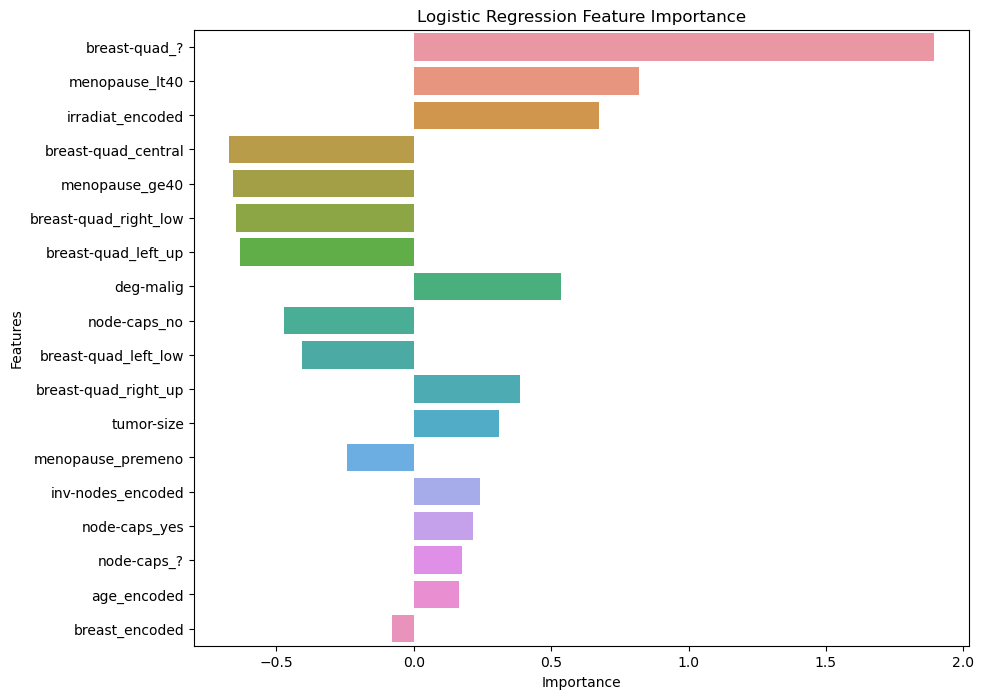

In [78]:
# Plot the feature importance
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_lr_df)
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Logistic Regression Feature Importance')
plt.show()

**Findings:**

The top three features for predicting breast cancer recurrence are:
- breast-quad?
- menopauce lt40
- irradiation

Features such as location of tumor (breast_encoded) and age_encoded yield coefficients close to zero suggesting they have minimal influence on the model's prediction. It is a bit surprising that age has little influence on prediction, as we saw trend with age recurrence during data exploration.

Can't extract much information from breast-quad? feature. Therefore, it may be beneficial to remove this feature.

In [79]:
features = X_train.columns 

# Create a DataFrame for feature importance
feature_importance_dt_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importances['Decision Tree']
}).sort_values(by='Importance', key = abs, ascending=False)

feature_importance_dt_df

,Feature,Importance
1,deg-malig,0.143988
2,age_encoded,0.132527
3,inv-nodes_encoded,0.115271
0,tumor-size,0.111214
4,breast_encoded,0.102529
8,menopause_premeno,0.072120
15,breast-quad_left_up,0.063179
5,irradiat_encoded,0.052830
11,node-caps_yes,0.045107
14,breast-quad_left_low,0.039554


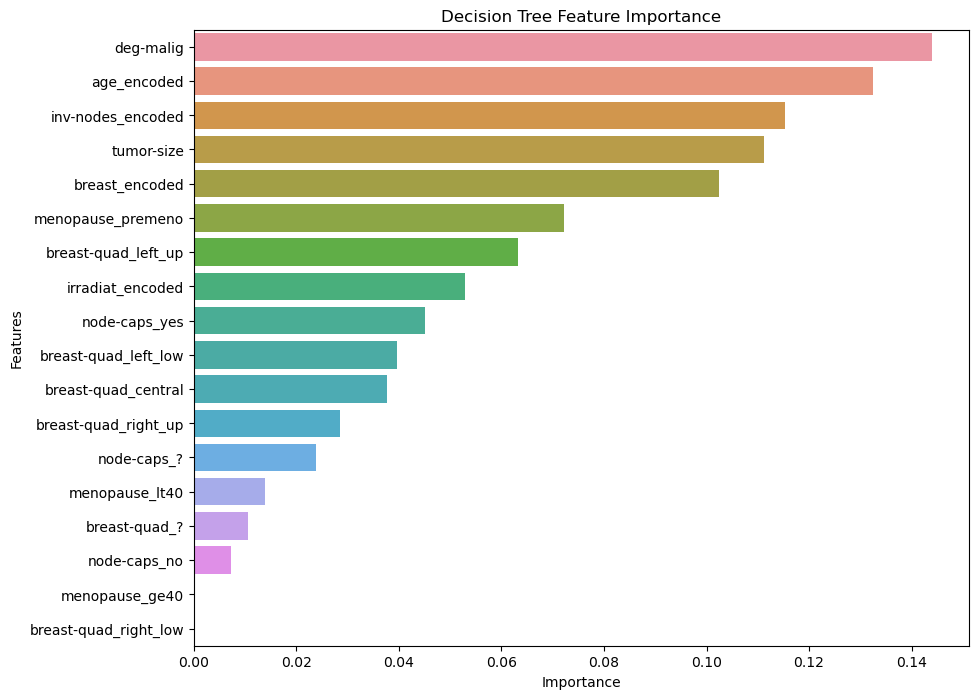

In [80]:
# Plot the feature importance
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_dt_df)
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Decision Tree Feature Importance')
plt.show()

**Findings:**

The most important features for predicting breast cancer recurrence in Decision Tree are:
- degree of malignancy
- number of lymph nodes involved
- age
- tumor-size

Menopausal stage in particular premenopause has a bigger impact compared to ge40 and lt40